# Transformer model fitting

This notebook contains the fitting of the Transformer model to all series in the dataset at the same time.

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Transformers.model_selection import TransformerHyperTune
from Transformers.data_processing import window_dataset_sequence_to_sequence
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,231.0,234.0,8.0,7.0,3.0,6.0,8.0,863.0,1496.0,4851.0
1,255.0,260.0,7.0,5.0,5.0,5.0,8.0,931.0,1438.0,4849.0
2,244.0,238.0,5.0,4.0,6.0,6.0,7.0,871.0,1412.0,4808.0
3,240.0,229.0,3.0,8.0,6.0,6.0,5.0,882.0,1413.0,4781.0
4,209.0,258.0,7.0,7.0,6.0,5.0,7.0,885.0,1353.0,4796.0


In [3]:
test_size = 4*24
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(904, 10)
(96, 10)


In [4]:
parameters = {
    "num_layers":[2],
    "num_heads":[4,6],
    "dff":[8,16,32],
    "dropout_rate":[0.1,0.3],
    "learning_rate":[0.01, 0.001],
    "batch_size":[8,16,32]
}

In [5]:
transformer_hypertune = TransformerHyperTune(
    num_features=10,
    window_size=24,
    parameters=parameters
)

In [6]:
transformer_model, scaler = transformer_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

Training model 0/72.
minimum 0 model's validation loss: 0.03156817704439163.
Training model 1/72.
minimum 1 model's validation loss: 0.03314104303717613.
Training model 2/72.
minimum 2 model's validation loss: 0.03972616046667099.
Training model 3/72.
minimum 3 model's validation loss: 0.04158477485179901.
Training model 4/72.
minimum 4 model's validation loss: 0.045587990432977676.
Training model 5/72.
minimum 5 model's validation loss: 0.0457792766392231.
Training model 6/72.
minimum 6 model's validation loss: 0.03759608045220375.
Training model 7/72.
minimum 7 model's validation loss: 0.03978570178151131.
Training model 8/72.
minimum 8 model's validation loss: 0.034829456359148026.
Training model 9/72.
minimum 9 model's validation loss: 0.042853862047195435.
Training model 10/72.
minimum 10 model's validation loss: 0.04750443249940872.
Training model 11/72.
minimum 11 model's validation loss: 0.051086582243442535.
Training model 12/72.
minimum 12 model's validation loss: 0.039527557

time: 690m, 49.0s

In [7]:
transformer_hypertune.best_params

{'num_layers': 2,
 'num_heads': 4,
 'dff': 8,
 'dropout_rate': 0.1,
 'learning_rate': 0.01,
 'batch_size': 8}

In [8]:
scaled_data = scaler.transform(data)

In [9]:
eval_ds = window_dataset_sequence_to_sequence(
    data=scaled_data,
    sequence_lenght=24,
    output_lenght=24,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [10]:
fit_values = transformer_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 2s 2s/step


In [11]:
orig_scale = scaler.inverse_transform(fit_0)

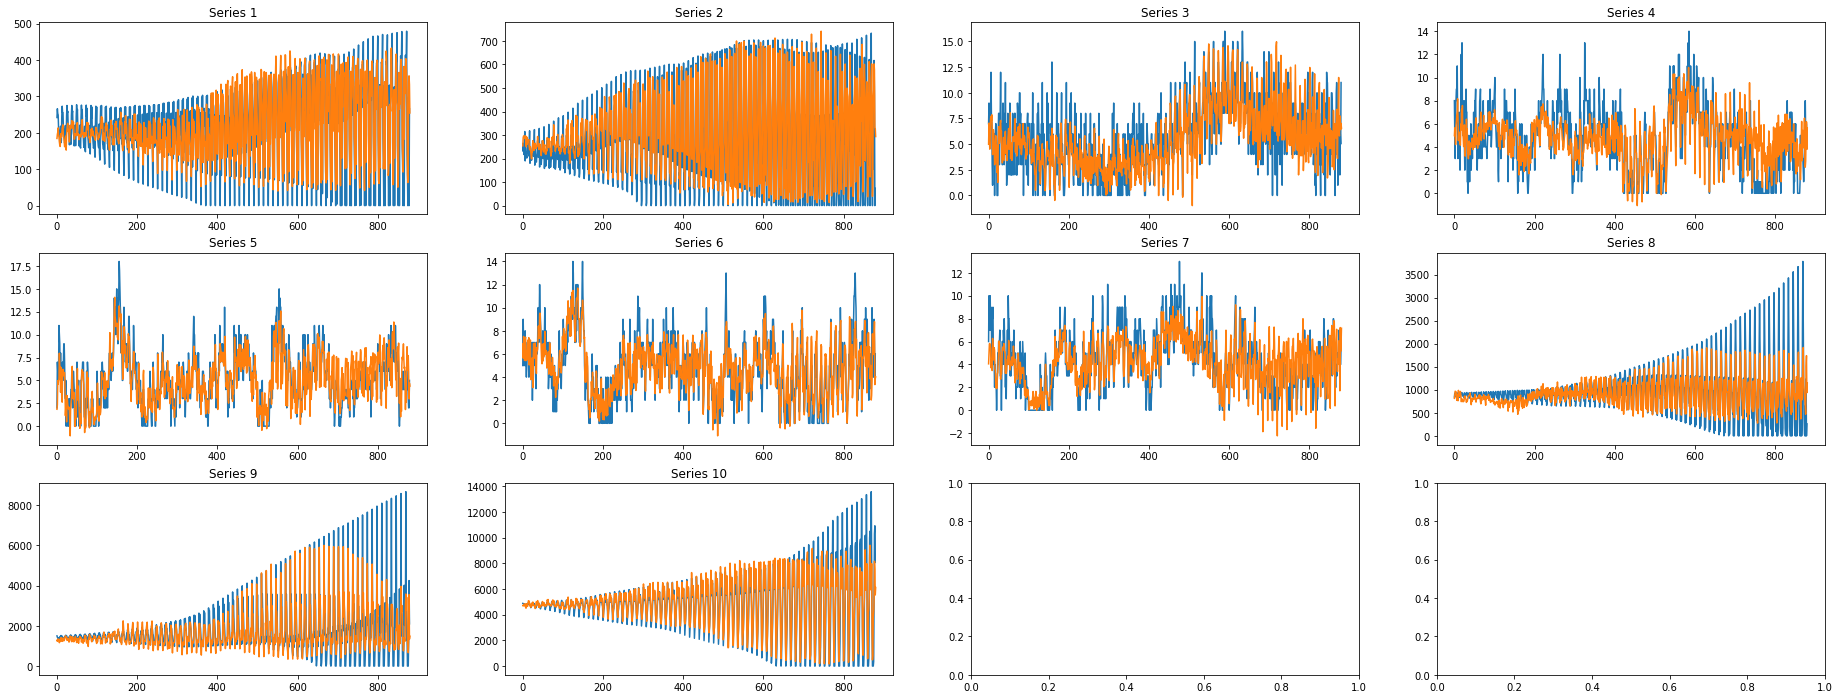

In [12]:
plot_fit(train_data[24:], orig_scale[:-3*24], cols=4)

In [13]:
transformer_model.summary()

Model: "transformer_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_73 (Encoder)        multiple                  3916      
                                                                 
 decoder_73 (Decoder)        multiple                  7416      
                                                                 
 dense_665 (Dense)           multiple                  110       
                                                                 
Total params: 11,442
Trainable params: 11,442
Non-trainable params: 0
_________________________________________________________________


In [14]:
transformer_model.save("transformer.tf")

INFO:tensorflow:Assets written to: transformer.tf\assets


INFO:tensorflow:Assets written to: transformer.tf\assets


In [15]:
transformer_model.save_weights('transformer_weights/transformer')

In [16]:
with open("transformer_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)